In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import os
import numpy as np
import math
import matplotlib
import CreateHD5F as chdf5
import ImageViewer as iv
import SimpleITK as sitk
from matplotlib.lines import Line2D

#%matplotlib notebook

In [3]:
def dataframe_of_f1scores(excel_path:str, sheet_name:str, filetype:list, range_ids, patient_ids=False):
    """
    The function takes in an excel file and creates a list of paths to the wanted file(s) (filetype).
    The wanted files are then converted to dataframes, and a singel dataframe containing all the
    'f1_scores' in the wanted files is returned.
    
    
    excel_path: path to excel file containing the paths to folders with experiment results
    sheet_name: name of the excel sheet you want to create a dataframe of
    filetype: filename of the file you want to collect from the result folder
    
    Returns a dataframe with all of f1_scores for the filetype for a given dataset.
    """
    dataframe = pd.read_excel(excel_path, sheet_name=sheet_name) #Create dataframe of excel sheet
    paths = list(dataframe['Result path']) #Get a list of folderpaths were the results are saved
    learning_rates = list(dataframe['Learning rate'])
    loss_functions = list(dataframe['Loss function'])
    IDs = list(dataframe['Experiment ID'])
    file_paths_352 = [] #List of paths for images with dimension 352x352
    file_paths_256 = [] #List of paths for images with dimension 256x256
    df = pd.DataFrame()

    for file in filetype:
        
        for i in range_ids:
            
            if (dataframe['Dataset'][0] == 'Oxytarget'): #If the dataset is Oxytarget then all the images have the same dimensions.
                paths[i] = paths[i] + '/' + file #List of paths for the patient.csv files
                if os.path.isfile(paths[i]): #Check if the file path exists
                    if df.empty: #Check if the dataframe is empty
                        df = pd.read_csv(paths[i]) #Add result to dataframe
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True) #Rename column
                        #df = df.rename(columns={'f1_score': IDs[i]})
                    else:
                        #If the dataframe is not empty, add columns with the score from the other results
                        df_temp = pd.read_csv(paths[i])
                        df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True)
                        #df = df.rename(columns={'f1_score': IDs[i]})
                
                    
            
            else: #For other datasets the images are of two different dimensions
                if file.endswith('352.csv'):
                    file_paths_352.append(str(paths[i]) + '/' + file)
                else:
                    file_paths_256.append(str(paths[i]) + '/' + file)
                
    if not dataframe['Dataset'][0] == 'Oxytarget':
        for i in range(len(file_paths_352)):
            if os.path.isfile(file_paths_352[i]) and os.path.isfile(file_paths_256[i]):

                if df.empty: #Check if the dataframe is empty
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df = df_352.append(df_256, ignore_index=True)
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                
                else:
                    #If the dataframe is not empty, add columns with the score from the other results
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df_temp = df_352.append(df_256, ignore_index=True)
                    df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                    
    if not patient_ids:
        df = df.drop(['patient_ids'], axis=1)
    
    return df

In [4]:
def swap_columns(df, c1, c2):
    """
    The function swaps the position of two columns (c1 and c2) in a dataframe (df).
    Returns new dataframe with swapped columns.
    """
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df = df.rename(columns={c1:c2, c2:c1})
    return df

In [5]:
def boxplot(dataframe, order, fontsize, labelsize, save=False):
    """
    The function creates boxplots based on learning rates and loss functions
    """
    fig = plt.figure()
    g = sns.FacetGrid(dataframe, col='Learning rate', row='Loss function', margin_titles=True)
    g.map(sns.violinplot,'Data', 'value', order=order, scale='width', inner='box', cut=0, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    #sns.set_style("whitegrid")
    sns.reset_orig()
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')


        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', r'DSC$_{\mathrm{P}}$')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    #g.set(ylim=(-0.35,1.1))
    g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig('hyperparameters_violinplot_cut0.pdf')
    
    

## Boxplots tuning hyperparameters (learning rate and loss function)

In [43]:
def main():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    ids_Oxy = [5,6,7,8,9,10]
    ids_LARC = [5,6,7,8,9,10]
    ids_Comb = [0,1,2,3,4,5]
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC',['patient_352.csv','patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb) 
    
    
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    #Column-names to be swapped
    col_names = list(Oxy.columns)
    
    for key in dictionary:               
        #Swapping order of columns
        dictionary[key] = swap_columns(dictionary[key], col_names[1], col_names[0])
        dictionary[key] = swap_columns(dictionary[key], col_names[4], col_names[3])
        
        #Re-organize the dataframe
        dictionary[key]['Data'] = key
    
    #Create one dataframe with all the datasets
    df = pd.concat([dictionary['OxyTarget'], dictionary['LARC-RRP'], dictionary['Combined']])
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    df[['Learning rate','Loss function']] = df.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
    
    #Plot as boxplots
    order = ['OxyTarget','LARC-RRP','Combined']
    boxplot(df, order, 12, 12, save=True)
    

<Figure size 792x576 with 0 Axes>

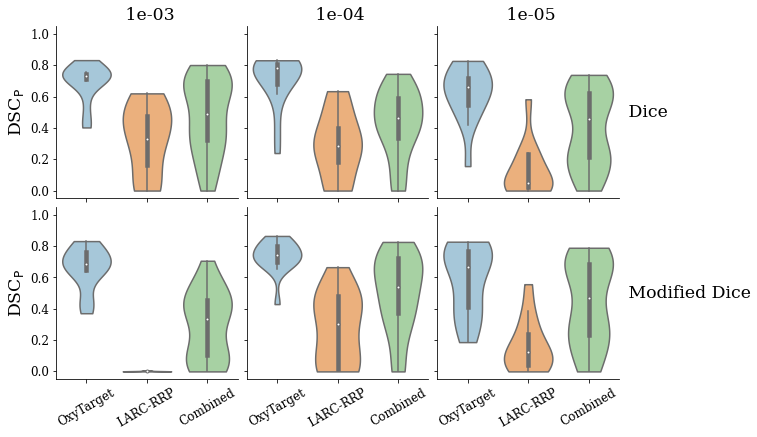

In [44]:
main()

## Scatter plots

In [103]:
def scatterplot(dataframe, x_value, y_value, filename, hue=None, save=False):
    fig = plt.figure(figsize=(11,8))
    sns.scatterplot(data=dataframe, x=x_value, y=y_value, hue=hue, palette='deep')
    plt.ylabel(r'DSC$_{\mathrm{P}}$')
    plt.xlabel('Patient IDs')
    #plt.title('Dataset: Combined, Learning rate: 0.00001')
    plt.ylim(-0.05,1.05)
    plt.show()
    
    if save:
        fig.savefig(filename)

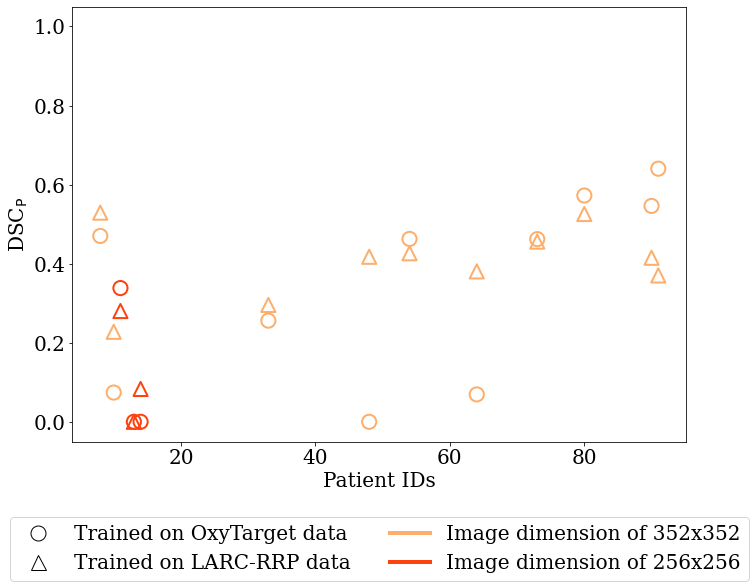

In [145]:
Oxy_ID_27_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_27_new/patient_352.csv')
Oxy_ID_27_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_27_new/patient_256.csv')

LARC_ID_35_352 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_35/patient_352.csv')
LARC_ID_35_256 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_35/patient_256.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Trained on OxyTarget data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='Trained on LARC-RRP data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], color='#fdae6b', label='Image dimension of 352x352', lw=4),
                    Line2D([0], [0], color='#fe420f', label='Image dimension of 256x256', lw=4),]

fig = plt.figure(figsize=(11,8))
plt.scatter(Oxy_ID_27_352['patient_ids'], Oxy_ID_27_352['f1_score'], marker='o', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(Oxy_ID_27_256['patient_ids'], Oxy_ID_27_256['f1_score'], marker='o', color='#fe420f', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_35_352['patient_ids'], LARC_ID_35_352['f1_score'], marker='^', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_35_256['patient_ids'], LARC_ID_35_256['f1_score'], marker='^', color='#fe420f', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.ylim(-0.05,1.05)
plt.show()

#fig.savefig('LARC_valPatients_trainedDiff_v2.pdf')


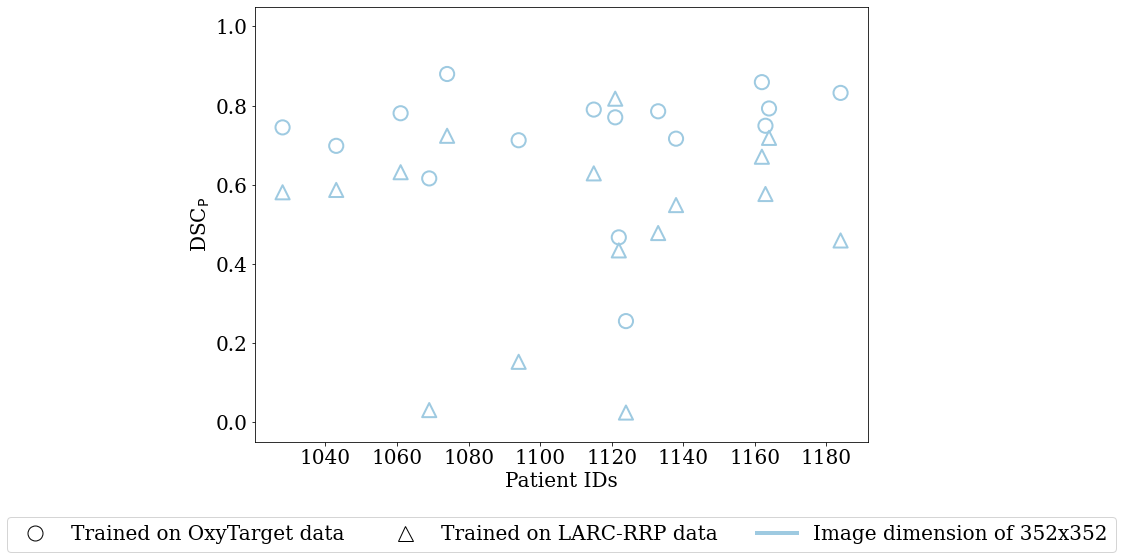

In [152]:
Oxy_ID_24 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/Oxy_new/Oxy_ID_24_new/patient.csv')
LARC_ID_38 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_38/patient.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Trained on OxyTarget data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='Trained on LARC-RRP data',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], color='#9ecae1', label='Image dimension of 352x352', lw=4),
                    ]

fig = plt.figure(figsize=(11,8))
plt.scatter(Oxy_ID_24['patient_ids'], Oxy_ID_24['f1_score'], marker='o', color='#9ecae1', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_38['patient_ids'], LARC_ID_38['f1_score'], marker='^', color='#9ecae1', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.ylim(-0.05,1.05)
plt.show()

fig.savefig('Oxy_valPatients_trainedDiff_v3.pdf')

In [119]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
Combined = dataframe_of_f1scores(excel_path, 'Combined',['patient_352.csv','patient_256.csv'], [0,1,2,3,4,5], patient_ids=True)
Combined['Dimension'] = 352
Combined['Dimension'][26:] = 256
print(Combined)
scatterplot(Combined, 'patient_ids', '1e-05+modified dice', hue='Dimension',save=True)

    patient_ids    1e-04+Dice    1e-03+Dice    1e-05+Dice  \
0           8.0  3.742796e-01  4.586493e-01  3.168455e-01   
1          10.0  3.824719e-01  3.162307e-01  4.575202e-01   
2          33.0  1.482200e-01  1.273156e-01  7.769662e-02   
3          48.0  3.509996e-01  4.041166e-01  4.164535e-01   
4          54.0  4.541155e-01  4.588831e-01  3.141851e-01   
5          64.0  1.849959e-01  3.257951e-01  7.187295e-02   
6          73.0  3.571896e-01  4.558449e-01  1.755793e-01   
7          80.0  6.356998e-01  6.698123e-01  5.278915e-01   
8          90.0  3.550093e-01  4.452312e-01  2.035720e-01   
9          91.0  7.182102e-14  6.426570e-14  6.940974e-14   
10       1115.0  6.850677e-01  7.025625e-01  7.101163e-01   
11       1121.0  7.360561e-01  6.678380e-01  6.321875e-01   
12       1122.0  5.763660e-01  4.380303e-01  4.175091e-01   
13       1124.0  6.723814e-02  1.161710e-01  1.917404e-01   
14       1133.0  6.986026e-01  6.368142e-01  6.447318e-01   
15       1138.0  6.00843

<ipython-input-119-35e250425d50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Combined['Dimension'][26:] = 256
/Users/ingvildaskimadde/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TypeError: scatterplot() missing 1 required positional argument: 'filename'

## Boxplot augmentation

In [36]:
def boxplot_aug(dataframe, fontsize, labelsize, title, colors, filename, save=False):
    
    fig = plt.figure(figsize=(11,8))
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    sns.violinplot(x=dataframe['Parameters'], y=dataframe['value'], scale='width', cut=0, palette=colors)
    #sns.boxplot(x=dataframe['Parameters'], y=dataframe['value'], palette=colors)
    plt.xlabel(None)
    plt.ylabel(r'DSC$_{\mathrm{P}}$')
    plt.title(title)
    #plt.xticks(rotation=30)
    plt.ylim(-0.05,1.05)
    #plt.ylim(-0.35,1.15)
    plt.show()
    
    if save:
        fig.savefig(filename)
    

In [76]:
def catplot_aug(dataframe, fontsize, labelsize, order, filename, save=False, title=None, colors=None):
    
    fig = plt.figure()
    #sns.set_palette(sns.color_palette(colors))
    #p = {'No': sns.color_palette(colors, 1), 'Default': sns.color_palette(colors, 1), 'Best Combination': sns.color_palette(colors, 1)}
    g = sns.catplot(x='Data', y='value', col='Parameters', hue='Parameters', data=dataframe, kind='violin')#, palette=p, margin_titles=True)
    #g.map(sns.violinplot,'Data', 'value', order=order, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
   
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', 'DSC')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    g.set(ylim=(-0.35,1.1))
    #g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig(filename)
    
    

In [45]:
def main_aug():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    
    #Define correct experiments (IDs)
    ids_LARC = [5,21,22,24]
    ids_Oxy = [5,14,15,16]
    ids_Comb = [0,14,13,15]
    
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC', ['patient_352.csv', 'patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb)
    print(Combined)
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    col_names_aug = ['No', 'Default', 'Best Combination']
    col_names_norm = ['No', 'Z-Score', 'Matched Hist', 'Matched Hist + Z-Score']

    for key in dictionary:
        print(key)
        for i in range(len(dictionary[key].columns)):
            dictionary[key].columns.values[i] = col_names_norm[i]
            print(dictionary[key].median())
        dictionary[key]['Data'] = key
        dictionary[key] = pd.melt(dictionary[key], id_vars=['Data'], var_name=['Parameters'])
        
        
    colors_Oxy = ['#9ecae1']#['#deebf7','#9ecae1','#3182bd']
    colors_LARC = ['#fdae6b'] #['#fee6ce','#fdae6b','#e6550d']
    colors_Comb = ['#a1d99b']#['#e5f5e0','#a1d99b','#31a354']
    
    boxplot_aug(dictionary['OxyTarget'], 20, 20, '', colors_Oxy, save=True)
    #catplot_aug(dictionary['LARC-RRP'], 20, 20, '', col_names, colors_LARC, save=False)

      1e-04+Dice  1e-04+Modified Dice  1e-04+Modified Dice  \
0   3.671686e-01             0.507238         5.079182e-01   
1   4.616767e-01             0.430496         1.170470e-01   
2   1.861577e-01             0.297437         3.701917e-01   
3   3.914741e-01             0.526312         3.961836e-01   
4   4.935207e-01             0.513766         5.216742e-01   
5   2.062322e-01             0.126080         2.026820e-01   
6   4.691816e-01             0.460785         3.354944e-01   
7   6.970897e-01             0.638360         5.228338e-01   
8   4.477368e-01             0.511292         3.708478e-01   
9   7.061698e-14             0.507499         6.550010e-01   
10  6.226847e-01             0.800600         7.650797e-01   
11  6.133394e-01             0.682754         7.133229e-01   
12  3.906581e-01             0.430426         5.761804e-01   
13  1.369210e-01             0.012487         2.666029e-01   
14  6.780299e-01             0.413367         6.809292e-01   
15  3.07

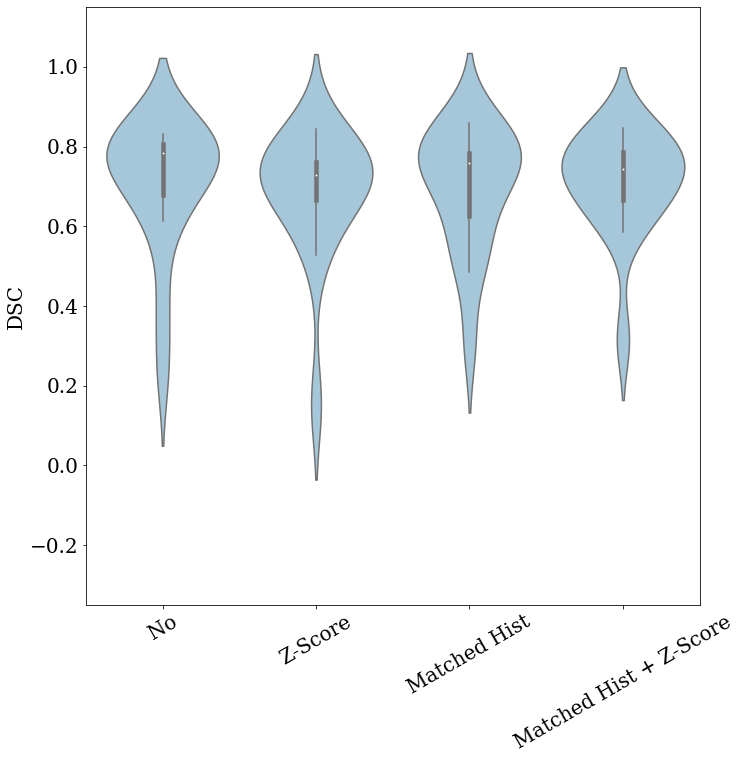

In [461]:
main_aug()

In [45]:
def main_dimensions(dataframe, id1, id2):
    
    #path_1_dim = list(dataframe['Result path'])[id1] + '/patient.csv'
    path_1_dim_352 = list(dataframe['Result path'])[id1] + '/patient_352.csv'
    path_1_dim_256 = list(dataframe['Result path'])[id1] + '/patient_256.csv'
    path_2_dim_352 = list(dataframe['Result path'])[id2] + '/patient_352.csv'
    path_2_dim_256 = list(dataframe['Result path'])[id2] + '/patient_256.csv' #Get a list of folderpaths were the results are saved
    
    #df1 = pd.read_csv(path_1_dim)
    df1_352 = pd.read_csv(path_1_dim_352)
    df1_256 = pd.read_csv(path_1_dim_256)
    df1 = df1_352.append(df1_256, ignore_index=True)
    #df1 = df1.rename(columns={'f1_score':'One dimension \n (352x352)'})
    df1 = df1.rename(columns={'f1_score':'Dice'})
    
    df2_352 = pd.read_csv(path_2_dim_352)
    df2_256 = pd.read_csv(path_2_dim_256)
    df = df2_352.append(df2_256, ignore_index=True)
    #df2 = df.rename(columns={'f1_score':'Two dimensions \n (352x352),(256x256)'})
    df2 = df.rename(columns={'f1_score':'Modified Dice'})
    
    df = df2.join(df1.set_index('patient_ids'), on='patient_ids') 
    df = df.drop(['patient_ids'], axis=1)
    
    df['Data'] = 'LARC-RRP'
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    colors_LARC = ['#fee6ce','#fdae6b']

    boxplot_aug(df, 20, 20, '', colors_LARC, 'test', save=False)

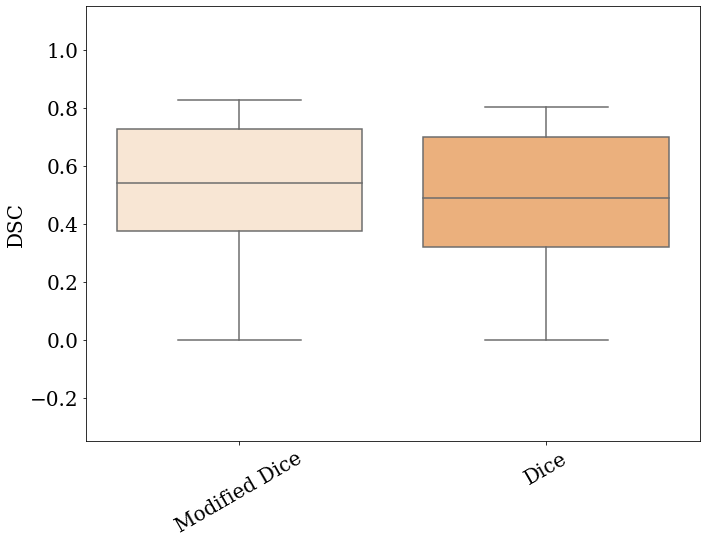

In [46]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
LARC_dim = pd.read_excel(excel_path, sheet_name='Combined_new') #Create dataframe of excel sheet

main_dimensions(LARC_dim, 1,3)

## Shallow machine learning model results

In [144]:
#text_path = '/Users/ingvild/Documents/Code/MasterThesis/Textfiles/LARC_tradSplit_patients_dict_352.txt'
text_path = '/Users/ingvild/Documents/Code/MasterThesis/Textfiles/Oxy_tradSplit_patients_dict.txt'
validation_patients = chdf5.read_dictionary(text_path)['val']

print(validation_patients)

{'352': [{'OxyTarget 121', 'OxyTarget 122', 'OxyTarget 043', 'OxyTarget 069', 'OxyTarget 028', 'OxyTarget 164', 'OxyTarget 074', 'OxyTarget 061', 'OxyTarget 163', 'OxyTarget 115', 'OxyTarget 162', 'OxyTarget 138', 'OxyTarget 124', 'OxyTarget 184', 'OxyTarget 094', 'OxyTarget 133'}]}


In [145]:
def create_paths_from_text(patients_dict, main_folder_path, ground_truth_folder_LARC, ground_truth_folder_Oxy):
    """
    Creates paths to the machine learning results for the patients in the validation set.
    
    patients_dict: dictionary of patients in validation set
    main_folder_path: path to experiment ID from machine learning result
    returns: list of paths to machine learning results
    """
    result_paths = []
    ground_truth_paths = []
    
    for key in patients_dict:
        patient_set = patients_dict[key][0]
        
        for patient in patient_set:
            print(patient)
            if patient.startswith('Oxy'):
                patient_ID = patient.split(' ')
                if patient_ID[1].startswith('0'):
                    if patient_ID[1].endswith('0'):
                        patient_ID[1] = patient_ID[1][1] + patient_ID[1][2]
                    else:
                        patient_ID[1] = patient_ID[1].strip('0')
                patient_path = main_folder_path + '/Oxytarget_' + patient_ID[1] + '_PRE.nii'
                truth_path = ground_truth_folder_Oxy + '/Oxytarget_' + patient_ID[1] + '_PRE/Manual_an.nii'
                result_paths.append(patient_path)
                ground_truth_paths.append(truth_path)
            
            else:
                patient_path = main_folder_path + '/' + patient + '.nii'
                result_paths.append(patient_path)
                truth_path = ground_truth_folder_LARC + '/' + patient + '/1 RTSTRUCT LARC_MRS1-label.nii'
                ground_truth_paths.append(truth_path)
    
    result_paths.sort()
    ground_truth_paths.sort()
    
    return result_paths, ground_truth_paths


#experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_14'
#manual_folder_Oxy = '/Volumes/LaCie/MasterThesis_Ingvild/Project/Oxytarget_preprocessed'
manual_folder_Oxy = '/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore'

experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5'
#manual_folder_LARC = '/Volumes/LaCie/MasterThesis_Ingvild/Project/LARC_T2_corrected'
manual_folder_LARC = '/Volumes/LaCie/MasterThesis_Ingvild/Data/LARC_cropped_MatchedHistZScore'

#experiment_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_23'

result_paths, gt_paths = create_paths_from_text(validation_patients, experiment_path, manual_folder_LARC, manual_folder_Oxy)

print(result_paths)
print(gt_paths)

OxyTarget 121
OxyTarget 122
OxyTarget 043
OxyTarget 069
OxyTarget 028
OxyTarget 164
OxyTarget 074
OxyTarget 061
OxyTarget 163
OxyTarget 115
OxyTarget 162
OxyTarget 138
OxyTarget 124
OxyTarget 184
OxyTarget 094
OxyTarget 133
['/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_115_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_121_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_122_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_124_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_133_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_138_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_162_PRE.nii', '/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/Oxytarget_163_PRE.nii', '/Volum

In [85]:
def calculate_dice(mask_a, mask_b):
    """
    Calculate DICE score for two binary masks (=sitk images)
    """
    npa1 = sitk.GetArrayFromImage(mask_a)
    npa2 = sitk.GetArrayFromImage(mask_b)

    dice = 2*np.count_nonzero(npa1 & npa2) / (np.count_nonzero(npa1) + np.count_nonzero(npa2))
    return dice

In [86]:
def dsc_performance(result_paths, ground_truth_paths):
    
    dsc_scores = []
    
    for i in range(len(result_paths)):
        
        print(result_paths[i])
        predicted_mask = sitk.ReadImage(result_paths[i]) > 0
        ground_truth_mask = sitk.ReadImage(ground_truth_paths[i]) > 0
        
        dsc = calculate_dice(predicted_mask, ground_truth_mask)
        dsc_scores.append(dsc)
    
    return dsc_scores

In [87]:
dsc_scores = dsc_performance(result_paths, gt_paths)
print(dsc_scores)

/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-008.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-010.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-033.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-048.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-054.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-064.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-073.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-080.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-090.nii
/Volumes/LaCie/MasterThesis_Ingvild/Project/results_postprocessed/ID_5/LARC-RRP-091.nii
[0.5455726592289225, 0.554091592743792, 0.2831964584927908, 0.5795022745517795, 0.44554491497651383, 0.25103200353394567

## Comparing shallow machine learning and deep learning

<IPython.core.display.Javascript object>


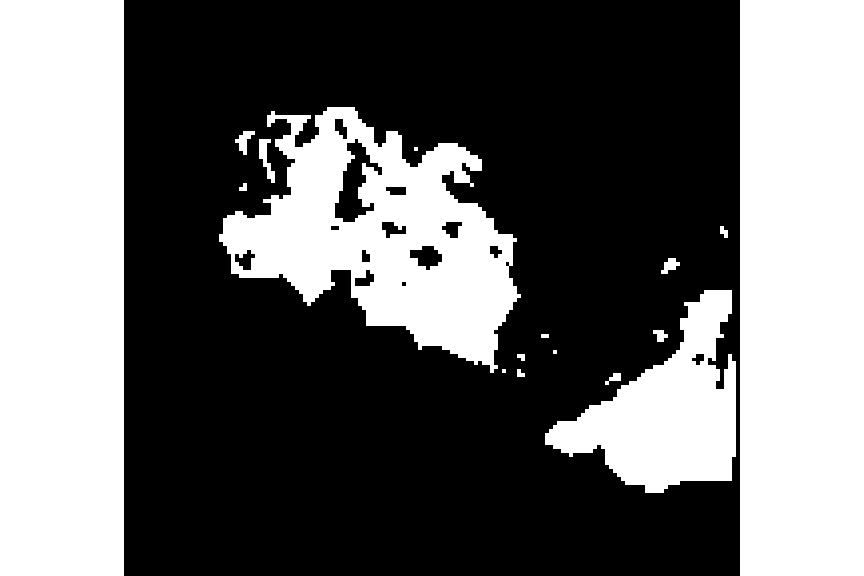

In [676]:
image_path = result_paths[1]
#mask_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/Oxytarget_preprocessed/Oxytarget_61_PRE/Manual_an.nii'
mask_path = '/Volumes/LaCie/MasterThesis_Ingvild/Project/LARC_T2_preprocessed/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii'

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

v = iv.Viewer(view_mode='1', mask_to_show=['a'])
v.set_image(image, label='image')
v.set_mask(mask, label='mask', color_rgb=[60, 180, 75])
v.show()

In [64]:
def main_compare(sml_dsc):
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    
    #Define correct experiments (IDs)
    ids_LARC = [42]
    ids_Oxy = [23]
    ids_Comb = [15]
    
    #Creating dataframes of det f1 scores of the validation patients
    #Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    #LARC = dataframe_of_f1scores(excel_path, 'LARC', ['patient_352.csv', 'patient_256.csv'], ids_LARC)
    LARC = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_43/patient.csv')
    LARC = LARC.drop(['patient_ids'], axis=1)
    #Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb)
    LARC['SML'] = sml_dsc
    print(LARC)
    #Creating dictionary of dataframes
    #dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    dictionary = {'LARC-RRP': LARC}
    
    col_names = ['SML', 'DL']

    for key in dictionary:
        print(key)
        print(dictionary[key].columns.values[1])
        dictionary[key] = swap_columns(dictionary[key], dictionary[key].columns.values[0], dictionary[key].columns.values[1])
        for i in range(len(dictionary[key].columns)):
            dictionary[key].columns.values[i] = col_names[i]
            print(dictionary[key].median())
        dictionary[key]['Data'] = key
        dictionary[key] = pd.melt(dictionary[key], id_vars=['Data'], var_name=['Parameters'])
    
    print(dictionary['LARC-RRP'])
        
        
    colors_Oxy = ['#3182bd','#9ecae1']#['#deebf7','#9ecae1','#3182bd']
    colors_LARC = ['#e6550d','#fdae6b'] #['#fee6ce','#fdae6b','#e6550d']
    colors_Comb = ['#31a354', '#a1d99b']#['#e5f5e0','#a1d99b','#31a354']
    
    boxplot_aug(dictionary['LARC-RRP'], 20, 20, '', colors_LARC, filename='LARC_352_compareNew_cut0_colors_noRot.pdf', save=True)


   f1_score       SML
0  0.569735  0.545573
1  0.116834  0.554092
2  0.276477  0.283196
3  0.487936  0.579502
4  0.492880  0.445545
5  0.114231  0.251032
6  0.483641  0.260735
7  0.568305  0.466392
8  0.472051  0.452168
9  0.268040  0.602142
LARC-RRP
SML
SML         0.459280
f1_score    0.477846
dtype: float64
SML    0.459280
DL     0.477846
dtype: float64
        Data Parameters     value
0   LARC-RRP        SML  0.545573
1   LARC-RRP        SML  0.554092
2   LARC-RRP        SML  0.283196
3   LARC-RRP        SML  0.579502
4   LARC-RRP        SML  0.445545
5   LARC-RRP        SML  0.251032
6   LARC-RRP        SML  0.260735
7   LARC-RRP        SML  0.466392
8   LARC-RRP        SML  0.452168
9   LARC-RRP        SML  0.602142
10  LARC-RRP         DL  0.569735
11  LARC-RRP         DL  0.116834
12  LARC-RRP         DL  0.276477
13  LARC-RRP         DL  0.487936
14  LARC-RRP         DL  0.492880
15  LARC-RRP         DL  0.114231
16  LARC-RRP         DL  0.483641
17  LARC-RRP         DL  0.56

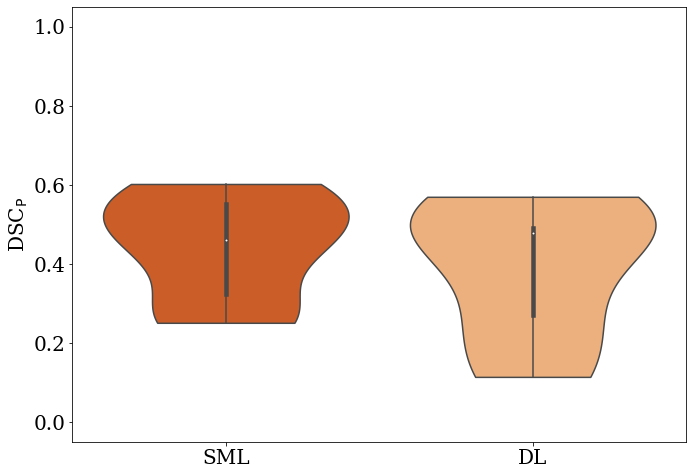

In [65]:
main_compare(dsc_scores)

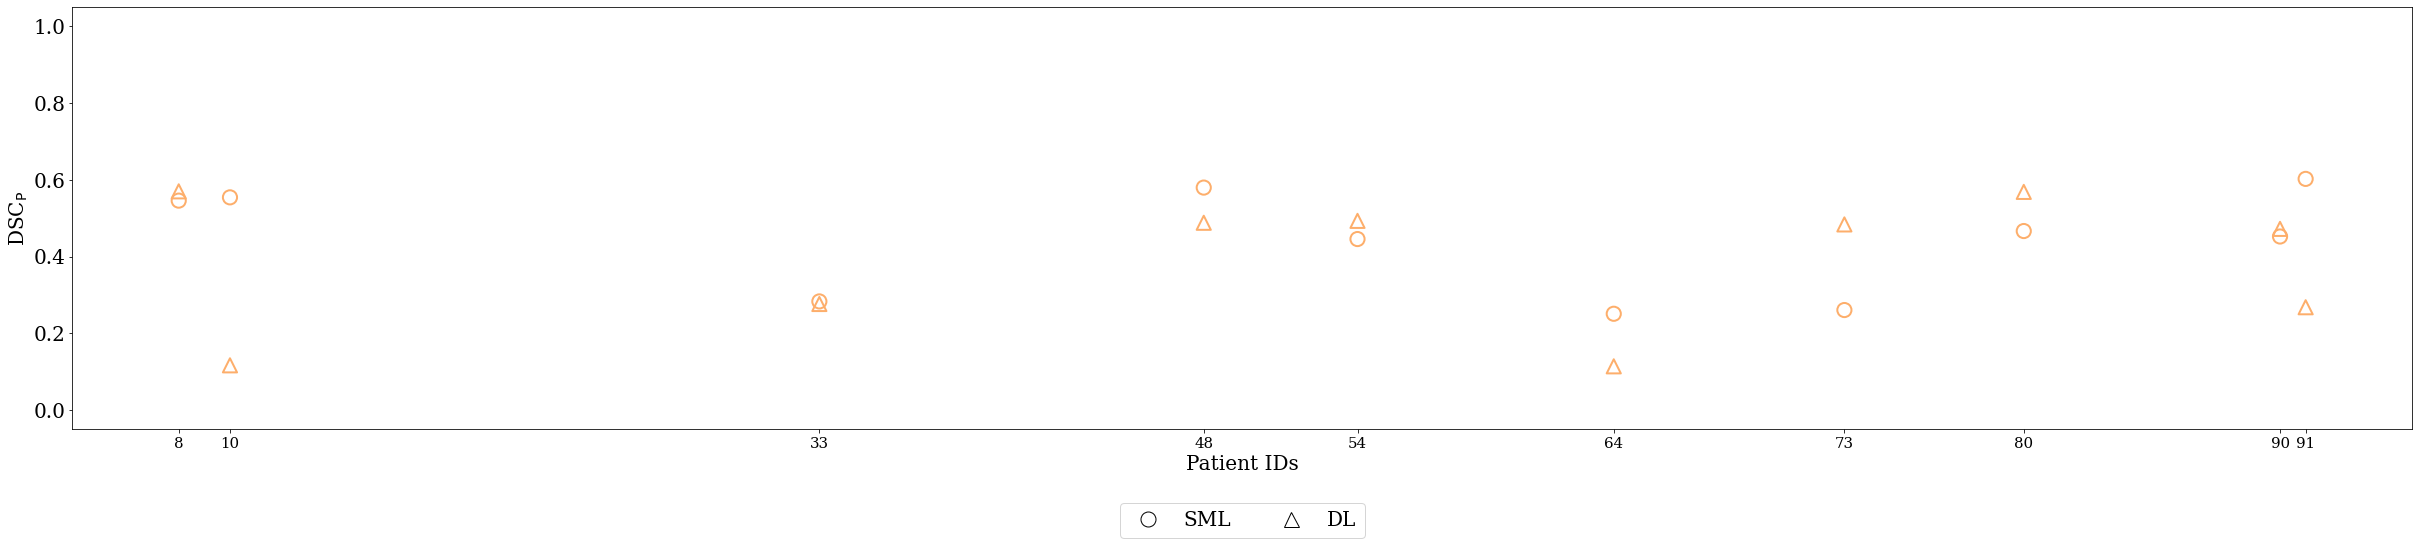

In [82]:
SML = dsc_scores
LARC_ID_43 = pd.read_csv('/Volumes/LaCie/MasterThesis_Ingvild/Experiments/LARC/LARC_ID_43/patient.csv')

legend_elements = [Line2D([0], [0], marker='o', color='k', label='SML',
                              markerfacecolor='none', markersize=15, linestyle='none'),
                    Line2D([0], [0], marker='^', color='k', label='DL',
                              markerfacecolor='none', markersize=15, linestyle='none')
                    ]

fig = plt.figure(figsize=(34,8))
plt.scatter(LARC_ID_43['patient_ids'], SML, marker='o', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.scatter(LARC_ID_43['patient_ids'], LARC_ID_43['f1_score'], marker='^', color='#fdae6b', facecolors='none',s=200, linewidths=2)
plt.ylabel(r'DSC$_{\mathrm{P}}$')
plt.xlabel('Patient IDs')
plt.xticks(LARC_ID_43['patient_ids'], size=15)
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.ylim(-0.05,1.05)
plt.tight_layout()
plt.show()

fig.savefig('LARC_352_valPatients_SML_DL.pdf')

In [146]:
def percentage_tumor_slices(gt_paths):

    tumor_slices = 0
    total_slices = 0
    tumor_voxels = 0
    total_voxels = 0

    for i in range(len(gt_paths)):
        print(gt_paths[i])
        mask = sitk.ReadImage(gt_paths[i])
        print(mask.GetSize())
        total_slices += mask.GetSize()[2]
        for j in range(mask.GetSize()[2]):
            mask_array = sitk.GetArrayFromImage(mask)
            if 1 in mask_array[:][:][j]:
                tumor_slices += 1
        tumor_voxels += np.count_nonzero(mask_array.flatten())
        total_voxels += len(mask_array.flatten())
        
    print('Number of slices with tumor:', tumor_slices)
    print('Total number of slices:', total_slices)
    print('Percentage tumor slices:', (tumor_slices/total_slices)*100)
    print('Percentage tumor voxels:', (tumor_voxels/total_voxels)*100)
    
    
percentage_tumor_slices(gt_paths)

/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_115_PRE/Manual_an.nii
(352, 352, 24)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_121_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_122_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_124_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_133_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_138_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_162_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_MatchedHistZScore/Oxytarget_163_PRE/Manual_an.nii
(352, 352, 26)
/Volumes/LaCie/MasterThesis_Ingvild/Data/Oxy_cropped_Mat

### K-fold plots

In [36]:
def catplot_kfold(dataframe, fontsize, labelsize, order, filename, save=False, title=None, colors=None):

    fig = plt.figure()
    #sns.set_palette(sns.color_palette(colors))
    #p = {'No': sns.color_palette(colors, 1), 'Default': sns.color_palette(colors, 1), 'Best Combination': sns.color_palette(colors, 1)}
    pal1 = {'OxyTarget':'#9ecae1', 'LARC-RRP':'#fdae6b'}
    g = sns.catplot(x='Parameters', y='value', col='Data', hue='Data', data=dataframe, kind='box', palette=pal1, aspect=1.5, margin_titles=True)#, palette=p, margin_titles=True)
    #hue_order = ['OxyTarget','LARC-RRP']
    
    #g = sns.FacetGrid(dataframe, col='Data', height=5, margin_titles=True)
    #g.map(sns.boxplot, 'Parameters', 'value', order=order)#, palette=['#9ecae1', '#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    #g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    matplotlib.rcParams["figure.figsize"] = (11, 8)
    #matplotlib.rcParams['text.usetex'] = True
   
    
    #ylabels = ['DSC', 'Modified DSC']
    #row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            #ax.set_title(ax.get_title().split('=')[1],
            #             fontsize='x-large')
            ax.set_title(' ',
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        #row += 1
    
    g.set(xticks=[-0.5,1,2,3,4])
    g.set_xticklabels(rotation=30, horizontalalignment='left')
    g.set_axis_labels('', r"DSC$_{\mathrm{S}}$")
    g.add_legend()
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    #g.set(ylim=(-0.35,1.1))
    g.set(ylim=(-0.05,1.05))
    #plt.tight_layout()
    plt.show()
    
    if save:
        g.savefig(filename)

In [37]:
def main_kfold_grid():

    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    df_LARC = pd.read_excel(excel_path, sheet_name='LARC')
    df_Oxy = pd.read_excel(excel_path, sheet_name='Oxy')
    paths_LARC = list(df_LARC['Result path'])
    paths_Oxy = list(df_Oxy['Result path'])
    
    # Define correct experiments (IDs)
    ids_LARC = [2, 1, 0, 3, 4]
    column_names_LARC = ['Fold 3', 'Fold 2', 'Fold 1', 'Fold 4', 'Fold 5']
    
    df_LARC_folds = pd.DataFrame()
    for i in range(len(column_names_LARC)):
        df_temp = pd.read_csv(paths_LARC[ids_LARC[i]] + '/logs.csv')
        df_LARC_folds[column_names_LARC[i]] = df_temp['val_dice']

    df_LARC_folds = swap_columns(df_LARC_folds, 'Fold 3', 'Fold 1')
    df_LARC_folds['Data'] = 'LARC-RRP'
    
    
    ids_Oxy = [4, 1, 2, 3, 0]
    column_names_Oxy = ['Fold 5', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 1']
    
    df_Oxy_folds = pd.DataFrame()
    for i in range(len(column_names_Oxy)):
        df_temp = pd.read_csv(paths_Oxy[ids_Oxy[i]] + '/logs.csv')
        df_Oxy_folds[column_names_Oxy[i]] = df_temp['val_dice']
    
    df_Oxy_folds = swap_columns(df_Oxy_folds, 'Fold 5', 'Fold 1')
    df_Oxy_folds['Data'] = 'OxyTarget'

    df = pd.concat([df_Oxy_folds, df_LARC_folds])
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    print(df)
    #Plot as boxplots
    order = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    catplot_kfold(df, 12, 12, order, filename='test', save=False)

          Data Parameters     value
0    OxyTarget     Fold 1  0.102091
1    OxyTarget     Fold 1  0.122695
2    OxyTarget     Fold 1  0.389209
3    OxyTarget     Fold 1  0.308327
4    OxyTarget     Fold 1  0.390153
..         ...        ...       ...
830   LARC-RRP     Fold 5       NaN
831   LARC-RRP     Fold 5       NaN
832   LARC-RRP     Fold 5       NaN
833   LARC-RRP     Fold 5       NaN
834   LARC-RRP     Fold 5       NaN

[835 rows x 3 columns]


<Figure size 792x576 with 0 Axes>

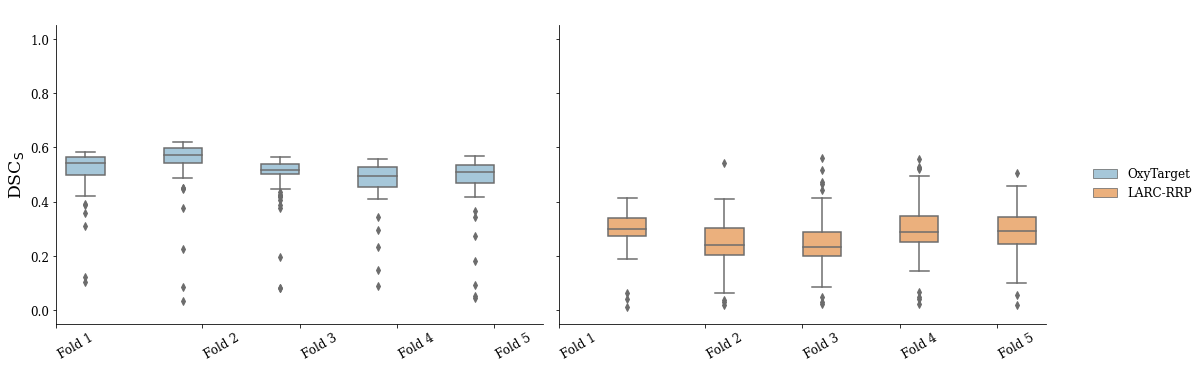

In [38]:
main_kfold_grid()